# Compare expected (CHyMErA) and observed (pyCROQUET) counts

Sample BAMs were quantified against the [CHyMErA paralog guide library](metadata/GSE144281_paralogLibrary.pyCROQUET.tsv) using [pyCROQUET](https://github.com/cancerit/pycroquet) version 1.5.1 in `dual-guide` mode with the following parameters:

* `--TinQ`   
* `--chunks 50000`

`TinQ`, or target in query, boundary mode is used as the reads are longer than the guide sequences, i.e. the reads contain, but are not restricted to the guide sequence.

Four datasets were generated using the `--rules` parameter:

* **exact** - exact matching (no `--rule` value)  
* **1M** - allowing 1 mismatch (`--rules M`)   
* **2M** - allowing 2 mismatches (`--rules MM`)  
* **3M** - allowing 3 mismatches (`--rules MMM`)  

In this notebook, we read in the results of running pyCROQUET on 23 samples and compare the observed counts generated by pyCROQUET (exact or allowing 1-3 mismatches) with the expected (published) counts for this library.

***

## Loading dependencies

There are minimal R library dependencies which need to be loaded for this comparison (you may need to install these before running commands in this notebook).

In [1]:
library(tidyverse)
library(scales)
library(ggridges)
library(ggforce)
library(ggrepel)
library(ggpubr)
library(ggsci)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




***

## Set constants

In [2]:
# Allow for different pyCROQUET rules
pyc_rules <- c('exact', '1M', '2M', '3M')

# Build dataset palette
dataset_palette <- pal_npg("nrc", alpha = 0.6)(5)
names(dataset_palette) <- c('CHyMErA', pyc_rules)

***

## Loading and preparing metadata

Metadata was downloaded for this study using [download_and_build_metadata.ipynb](../download_and_build_metadata.ipynb). This metadata can be filtered to get the paralog-library-specific information.

In [3]:
# Load sample metadata (all runs in project)
sample_metadata <- read.delim(file.path('metadata', 'PRJNA603290_GSE144281_sample_metadata.tsv'), sep = "\t", header = T)

# Filter sample metadata to get only runs related to paralog library
sample_metadata <- sample_metadata %>% filter(grepl('Paralog', Dataset))

In order to bring together the pyCROQUET samples, which used the SRA run accession, and the expected counts, which use a sample lable (not provided for all samples in metadata), we first generate the respective `Sample.Label` from the `Sample.Name`.

In [4]:
# Add sample label for paralogs
sample_metadata <- sample_metadata %>%
    rowwise() %>%
    mutate('Sample.Label' = case_when(!grepl('Torin', Sample.Name) ~ str_replace(Sample.Name, ' Paralogue/Dual ', '.'),
                                      grepl('Torin', Sample.Name) ~ str_replace(str_replace(str_replace(Sample.Name, ' Paral Torin ', '.Torin.'), "[+]" , '.plus'), ' ' , '')),
          .after = 'Sample.Name') 

For later plots, it is useful to be able to group samples, in this case by treatment status, cell line, timepoint or replicate.

In [5]:
# Split Sample.Label to give cell line, treatment status, timepoint and replicate
sample_metadata <- sample_metadata %>%
    rowwise() %>%
    mutate('cell_line' = str_split(Sample.Label, '\\.', simplify = T)[1], .after = Sample.Label) %>%
    mutate('timepoint' = case_when(grepl('T0', Sample.Label) ~ 'T0',
                               treatment == "non-treated" & !grepl('T0', Sample.Label) ~ str_sub(str_split(Sample.Label, '\\.', simplify = T)[2], end = -2),
                               treatment == "torin1" ~ str_sub(str_split(Sample.Label, '\\.', simplify = T)[3], end = -2)), .after = 'cell_line') %>%
    mutate('replicate' = case_when(grepl('T0', Sample.Label) ~ 'A',
                                   treatment == "non-treated" & !grepl(' T0', Sample.Label) ~str_sub(str_split(Sample.Label, '\\.', simplify = T)[2], start = -1),
                                   treatment == "torin1" ~ str_sub(str_split(Sample.Label, '\\.', simplify = T)[3], start = -1)), .after = 'timepoint')

# Show preview
head(sample_metadata)

Sample.ID,Run,Dataset,Sample.Name,Sample.Label,cell_line,timepoint,replicate,Label,R1,⋯,ReleaseDate,GEO.Sample.Name,SRA.Study,annotation_file,cas_protein,Cell_Line,crispr_library,library_file,source_name,treatment
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
HH-79,SRR10969645,HumanParalogScreen_NovaSeq_20181109,HAP1 Paralogue/Dual T0,HAP1.T0,HAP1,T0,A,NA,Moffat_HH-79_S1_R1_001.fastq.gz,⋯,2020-02-04T00:00:00Z,GSM4284932,SRP245362,human_dualTargetingParalog_libV3_annot.txt,LbCas12a,HAP1,CHyMErA Dual-Targeting & Paralog Library,human_dualTargetingParalog_libV3_guides.fasta,dual-guide amplicon,non-treated
HH-80,SRR10969649,HumanParalogScreen_NovaSeq_20181109,HAP1 Paralogue/Dual T18A,HAP1.T18A,HAP1,T18,A,NA,Moffat_HH-80_S2_R1_001.fastq.gz,⋯,2020-02-04T00:00:00Z,GSM4284932,SRP245362,human_dualTargetingParalog_libV3_annot.txt,LbCas12a,HAP1,CHyMErA Dual-Targeting & Paralog Library,human_dualTargetingParalog_libV3_guides.fasta,dual-guide amplicon,non-treated
HH-81,SRR10969650,HumanParalogScreen_NovaSeq_20181109,HAP1 Paralogue/Dual T18B,HAP1.T18B,HAP1,T18,B,NA,Moffat_HH-81_S3_R1_001.fastq.gz,⋯,2020-02-04T00:00:00Z,GSM4284932,SRP245362,human_dualTargetingParalog_libV3_annot.txt,LbCas12a,HAP1,CHyMErA Dual-Targeting & Paralog Library,human_dualTargetingParalog_libV3_guides.fasta,dual-guide amplicon,non-treated
HH-82,SRR10969651,HumanParalogScreen_NovaSeq_20181109,HAP1 Paralogue/Dual T18C,HAP1.T18C,HAP1,T18,C,NA,Moffat_HH-82_S4_R1_001.fastq.gz,⋯,2020-02-04T00:00:00Z,GSM4284932,SRP245362,human_dualTargetingParalog_libV3_annot.txt,LbCas12a,HAP1,CHyMErA Dual-Targeting & Paralog Library,human_dualTargetingParalog_libV3_guides.fasta,dual-guide amplicon,non-treated
HH-83,SRR10969661,HumanParalogScreen_NovaSeq_20181109,RPE1 Paralogue/Dual T0,RPE1.T0,RPE1,T0,A,NA,Moffat_HH-83_S5_R1_001.fastq.gz,⋯,2020-02-04T00:00:00Z,GSM4284934,SRP245362,human_dualTargetingParalog_libV3_annot.txt,LbCas12a,RPE1,CHyMErA Dual-Targeting & Paralog Library,human_dualTargetingParalog_libV3_guides.fasta,dual-guide amplicon,non-treated
HH-84,SRR10969665,HumanParalogScreen_NovaSeq_20181109,RPE1 Paralogue/Dual T24A,RPE1.T24A,RPE1,T24,A,NA,Moffat_HH-84_S6_R1_001.fastq.gz,⋯,2020-02-04T00:00:00Z,GSM4284934,SRP245362,human_dualTargetingParalog_libV3_annot.txt,LbCas12a,RPE1,CHyMErA Dual-Targeting & Paralog Library,human_dualTargetingParalog_libV3_guides.fasta,dual-guide amplicon,non-treated


***

## Loading expected (CHyMErA) raw count data

Published raw counts for the 23 samples analysed with the paralog library were downloaded from [GEO](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE144nnn/GSE144281/suppl/GSE144281_paralogLibrary_rawCounts_NovaSeq_18Sept18.txt.gz) in [download_and_build_metadata.ipynb](../download_and_build_metadata.ipynb). The inital matrix has the samples by column. For ease of analysis we gather the data into two columns: sample (i.e. the sample label) and expected_counts (i.e. the published raw counts). Each row represents the frequency of a guide in a particular sample.

In [6]:
# Read expected counts downloaded from GEO
expected_counts <- read.delim(file.path('metadata', 'GSE144281_paralogLibrary_rawCounts_NovaSeq_18Sept18.txt'), header = T, sep = "\t")

# Move samples (column headers) into a single column ready for combining with observed counts (generated by pyCROQUET)
expected_counts <- expected_counts %>%
    gather(sample, expected_counts, -names(expected_counts)[1:12])

# Show counts for first gene pair in first sample
head(expected_counts)

,ID,Library,Gene.symbol1,Gene.symbol2,Cas9.Target.Site,Cas9.Guide.Source,Cas9.Guide,Cas9.Guide.Type,Cpf1.Target.Site,Cpf1.Guide,Cpf1.Guide.Type,CNN.Score,sample,expected_counts
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
1,ParalogV3_000001,DualTargeting,RPL4,---,chr15:66499639-66499659_-,TKOv3,GTTGCAGCACAAGCTCCGGG,exonic,chr15:66500156-66500179_-,TAGCAAGAAGATCCATCGCAGAG,exonic,0.8760698,HAP1.Torin.T12B,3
2,ParalogV3_000002,DualTargeting,RPL4,---,chr15:66499639-66499659_-,TKOv3,GTTGCAGCACAAGCTCCGGG,exonic,chr15:66503507-66503530_-,GGCGTGTGCTCGCCCACTGATAT,exonic,0.8545525,HAP1.Torin.T12B,2
3,ParalogV3_000003,DualTargeting,RPL4,---,chr15:66499639-66499659_-,TKOv3,GTTGCAGCACAAGCTCCGGG,exonic,chr15:66501484-66501507_-,TAGGTCTATGCCTCTCAGCGAAT,exonic,0.7979501,HAP1.Torin.T12B,0
4,ParalogV3_000004,DualTargeting,RPL4,---,chr15:66499639-66499659_-,TKOv3,GTTGCAGCACAAGCTCCGGG,exonic,chr16:56543346-56543369_-,AGGGAAGCCCAAGATCCACACGT,intergenic,0.7987322,HAP1.Torin.T12B,45
5,ParalogV3_000005,DualTargeting,RPL4,---,chr15:66499643-66499663_-,KRB,ATTTGTTGCAGCACAAGCTC,exonic,chr15:66500156-66500179_-,TAGCAAGAAGATCCATCGCAGAG,exonic,0.8760698,HAP1.Torin.T12B,21
6,ParalogV3_000006,DualTargeting,RPL4,---,chr15:66499643-66499663_-,KRB,ATTTGTTGCAGCACAAGCTC,exonic,chr15:66503507-66503530_-,GGCGTGTGCTCGCCCACTGATAT,exonic,0.8545525,HAP1.Torin.T12B,2


***

## Reading in observed (pyCROQUET counts)

Each of the 23 samples was quantified independently using pyCROQUET. The quantification was run using four different parameters: exact matching (`observed_counts_exact`), 1 mismatches (`observed_counts_1M`), 2 mismatch (`observed_counts_2M`) or 3 mismatches (`observed_counts_3M`), such that there are four count files per sample, one per dataset. We read in the individual counts files and combine them into a data frame containing the counts per sample and dataset.

In [7]:
# Create empty list to hold count matrix for each rule
observed_counts_list <- list()

# Loop over rules
for (rl in pyc_rules) {
    # Create empty data frame to store observed counts
    df <- data.frame()
    # Loop over SRA run accessions in filtered sample metadata
    for (rid in sample_metadata$Run) {
        # Read in count file generated by pyCROQUET
        count_file <- file.path('results', paste0(rid, '_', rl, '.counts.tsv.gz'))
        # Check file exists, if not print out the missing run and rule
        if (file.exists(count_file)) {
            # Read in counts for the sample, update id column name and add the run accession
            sample_counts <- read.delim(count_file, skip = 2, header = T, sep = "\t")
            colnames(sample_counts)[1] <- 'id'
            sample_counts$Run <- rid # allows linking to metadata (i.e. sample label)
            colnames(sample_counts) <- sub("reads_.+", paste0("observed_counts_", rl), colnames(sample_counts))
            # Append counts to data frame
            if (is.null(observed_counts_list[[rl]])) {
                observed_counts_list[[rl]] <- sample_counts
            } else {
                observed_counts_list[[rl]] <- rbind(observed_counts_list[[rl]], sample_counts)
            }
        } else {
            # Print run accession and rule if count file is missing
            print(paste("No count file for:", rl, rid))
        }
    }
}

# Create a single matrix with all observed counts
observed_counts <- data.frame()

# Loop over rules
for (rl in pyc_rules) {
       # Append counts to data frame
        if (nrow(observed_counts) == 0) {
            observed_counts <- observed_counts_list[[rl]]
        } else {
            observed_counts <- observed_counts %>% 
                full_join(observed_counts_list[[rl]], by = c("id", "sgrna_ids", "sgrna_seqs", "gene_pair_id", "unique_guide", "Run")) %>%
                relocate('Run', .after = 'unique_guide')
        }
}

# Show preview
head(observed_counts)

,id,sgrna_ids,sgrna_seqs,gene_pair_id,unique_guide,Run,observed_counts_exact,observed_counts_1M,observed_counts_2M,observed_counts_3M
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>
1,ParalogV3_000001,chr15:66499639-66499659_-|chr15:66500156-66500179_-,GTTGCAGCACAAGCTCCGGG|TAGCAAGAAGATCCATCGCAGAG,RPL4|---,1,SRR10969645,9,9,9,9
2,ParalogV3_000002,chr15:66499639-66499659_-|chr15:66503507-66503530_-,GTTGCAGCACAAGCTCCGGG|GGCGTGTGCTCGCCCACTGATAT,RPL4|---,1,SRR10969645,34,46,47,47
3,ParalogV3_000003,chr15:66499639-66499659_-|chr15:66501484-66501507_-,GTTGCAGCACAAGCTCCGGG|TAGGTCTATGCCTCTCAGCGAAT,RPL4|---,1,SRR10969645,40,43,43,44
4,ParalogV3_000004,chr15:66499639-66499659_-|chr16:56543346-56543369_-,GTTGCAGCACAAGCTCCGGG|AGGGAAGCCCAAGATCCACACGT,RPL4|---,1,SRR10969645,17,23,22,22
5,ParalogV3_000005,chr15:66499643-66499663_-|chr15:66500156-66500179_-,ATTTGTTGCAGCACAAGCTC|TAGCAAGAAGATCCATCGCAGAG,RPL4|---,1,SRR10969645,78,81,82,81
6,ParalogV3_000006,chr15:66499643-66499663_-|chr15:66503507-66503530_-,ATTTGTTGCAGCACAAGCTC|GGCGTGTGCTCGCCCACTGATAT,RPL4|---,1,SRR10969645,40,45,46,46


***

## Combining observed (pyCROQUET) and expected (CHyMErA) raw counts

The data frame containing all observed counts (pyCROQUET) is combined with the expected counts (CHyMErA). Each row represents the frequency of each oligo in a particular sample and each column represents the data set or rules applied.

In [8]:
# Combine metadata and expected counts with observed counts
all_counts <- observed_counts %>%
    left_join(sample_metadata %>% select(Run, Sample.ID, Sample.Label), by = 'Run') %>%
    left_join(expected_counts %>% select('id' = ID, 'Sample.Label' = sample, expected_counts), by = c('id', 'Sample.Label')) %>%
    relocate(Sample.ID, Sample.Label, .before = 'id')

# Show preview
head(all_counts)

,Sample.ID,Sample.Label,id,sgrna_ids,sgrna_seqs,gene_pair_id,unique_guide,Run,observed_counts_exact,observed_counts_1M,observed_counts_2M,observed_counts_3M,expected_counts
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>
1,HH-79,HAP1.T0,ParalogV3_000001,chr15:66499639-66499659_-|chr15:66500156-66500179_-,GTTGCAGCACAAGCTCCGGG|TAGCAAGAAGATCCATCGCAGAG,RPL4|---,1,SRR10969645,9,9,9,9,9
2,HH-79,HAP1.T0,ParalogV3_000002,chr15:66499639-66499659_-|chr15:66503507-66503530_-,GTTGCAGCACAAGCTCCGGG|GGCGTGTGCTCGCCCACTGATAT,RPL4|---,1,SRR10969645,34,46,47,47,47
3,HH-79,HAP1.T0,ParalogV3_000003,chr15:66499639-66499659_-|chr15:66501484-66501507_-,GTTGCAGCACAAGCTCCGGG|TAGGTCTATGCCTCTCAGCGAAT,RPL4|---,1,SRR10969645,40,43,43,44,44
4,HH-79,HAP1.T0,ParalogV3_000004,chr15:66499639-66499659_-|chr16:56543346-56543369_-,GTTGCAGCACAAGCTCCGGG|AGGGAAGCCCAAGATCCACACGT,RPL4|---,1,SRR10969645,17,23,22,22,23
5,HH-79,HAP1.T0,ParalogV3_000005,chr15:66499643-66499663_-|chr15:66500156-66500179_-,ATTTGTTGCAGCACAAGCTC|TAGCAAGAAGATCCATCGCAGAG,RPL4|---,1,SRR10969645,78,81,82,81,76
6,HH-79,HAP1.T0,ParalogV3_000006,chr15:66499643-66499663_-|chr15:66503507-66503530_-,ATTTGTTGCAGCACAAGCTC|GGCGTGTGCTCGCCCACTGATAT,RPL4|---,1,SRR10969645,40,45,46,46,48


These results are written to [post-analysis/observed_vs_expected_counts.tsv](results/observed_vs_expected_counts.tsv).

In [9]:
# Write this table to file
write.table(all_counts, file.path('post-analysis', 'observed_vs_expected_counts.tsv'), sep = "\t", row.names = F, quote = F)

*** 

## Reshaping the data

While for some summaries and plots it's useful to have datasets in separate columns, for others, it's necessary to gather the data such that a row represents the frequency of a guide, in a particular sample from a particular dataset.

In [10]:
# Gather datasets into a single column with associated values
gathered_counts <- all_counts %>% 
    select(Sample.Label, starts_with('expected'), starts_with('observed')) %>% 
    gather(Dataset, Counts, -Sample.Label) %>%
    mutate('Dataset' = str_replace(Dataset, 'observed_counts_', '')) %>%
    mutate('Dataset' = str_replace(Dataset, 'expected_counts', 'CHyMErA')) %>%
    mutate('Dataset' = factor(Dataset, levels = c('CHyMErA', pyc_rules)))

# Show preview
head(gathered_counts)

,Sample.Label,Dataset,Counts
,<chr>,<fct>,<int>
1,HAP1.T0,CHyMErA,9
2,HAP1.T0,CHyMErA,47
3,HAP1.T0,CHyMErA,44
4,HAP1.T0,CHyMErA,23
5,HAP1.T0,CHyMErA,76
6,HAP1.T0,CHyMErA,48


In [11]:
# Gather datasets into a single column with associated values leaving expected counts as a separate column
gathered_counts_with_expected <- all_counts %>% 
    select(id, Sample.Label, 'CHyMErA' = expected_counts, starts_with('observed')) %>% 
    gather(Dataset, Counts, -Sample.Label, -CHyMErA, -id) %>%
    mutate('Dataset' = str_replace(Dataset, 'observed_counts_', '')) %>%
    mutate('Dataset' = factor(Dataset, levels = c(pyc_rules)))

# Show preview
head(gathered_counts_with_expected)

,id,Sample.Label,CHyMErA,Dataset,Counts
,<chr>,<chr>,<int>,<fct>,<int>
1,ParalogV3_000001,HAP1.T0,9,exact,9
2,ParalogV3_000002,HAP1.T0,47,exact,34
3,ParalogV3_000003,HAP1.T0,44,exact,40
4,ParalogV3_000004,HAP1.T0,23,exact,17
5,ParalogV3_000005,HAP1.T0,76,exact,78
6,ParalogV3_000006,HAP1.T0,48,exact,40


*** 

## Distribution of counts

First, we'll visualise the distribution or general shape of the data. To help with this, we should look at some basic statistics for the raw counts to allow us to set meaningful plot limits.

In [12]:
# Get selected count quantiles
gathered_counts %>% summarise(enframe(quantile(Counts, c(0.90, 0.95, 0.99)), "quantile", "counts"))

quantile,counts
<chr>,<dbl>
90%,334
95%,514
99%,1111


Using this threshold, we can then build a density ridgeline plot with datasets on the y-axis and counts on the x-axis. *Note: this plot will be limited to counts <= 500).*

In [13]:
# Set maximum value of counts to include in plots (includes ~95% of count data)
max_counts_to_plot <- 500

Picking joint bandwidth of 4.38

Picking joint bandwidth of 4.38



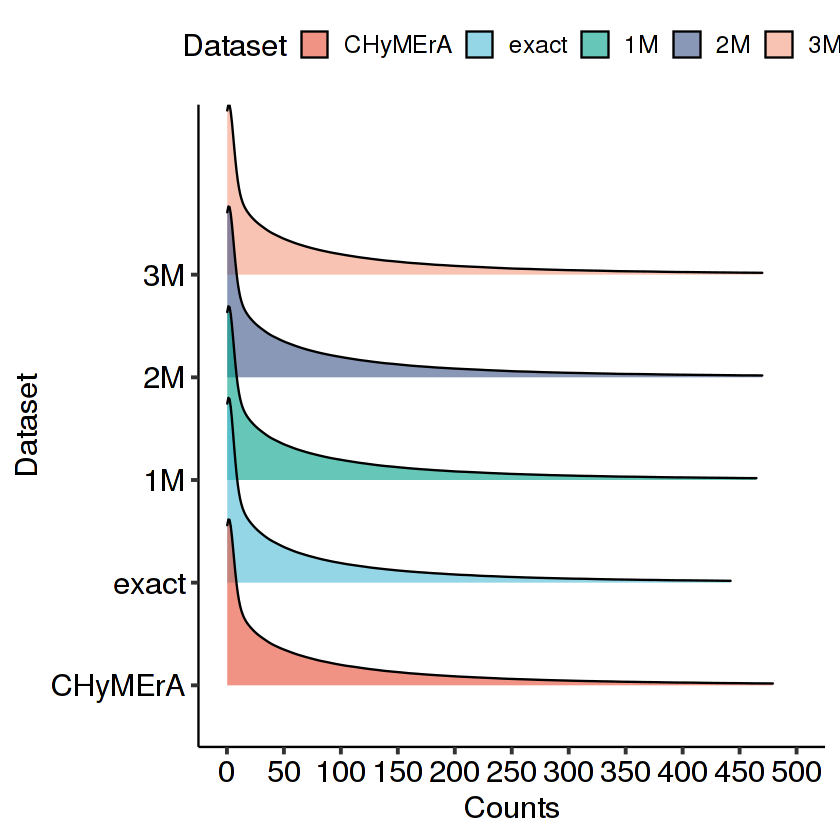

In [14]:
# Build ridgeline density plots from dataset counts
dataset_counts_ridgeline <- 
    ggplot(gathered_counts %>% filter(Counts <= max_counts_to_plot), aes(x = Counts, y = Dataset, fill = Dataset)) + 
      geom_density_ridges(rel_min_height = 0.01) +
      scale_fill_manual(values = dataset_palette) +
      scale_x_continuous(breaks = pretty_breaks(12), limits = c(0, max_counts_to_plot)) +
      theme_pubr(base_size = 18)

# Save plot to file
ggsave(file.path('post-analysis', 'dataset_counts_lteq500_ridgeline_density.png'), 
       dataset_counts_ridgeline,
       device = 'png', dpi = 200,
       width = 12, height = 10)

# Show plot
dataset_counts_ridgeline

***

## Correlation of raw count datasets

Next, we want to look at the Spearman's correation coefficient between each of the pyCROQUET datasets and the expected counts for all samples and all oligos.

In [15]:
# Calculate correlation between each observed dataset to the expected counts
correlation_to_expected <- all_counts %>% 
  select(Sample.Label, expected_counts, starts_with('observed_counts')) %>%
  group_by(Sample.Label) %>%
  summarize(across(observed_counts_exact:observed_counts_3M, ~cor(.x, expected_counts, method = 'spearman'))) %>%
  pivot_longer(!Sample.Label, values_to = "Correlation", names_to = "Dataset") %>%
  mutate('Dataset' = str_replace(Dataset, 'observed_counts_', '')) %>%
  mutate('Dataset' = factor(Dataset, levels = pyc_rules))

# Show preview
head(correlation_to_expected)

Sample.Label,Dataset,Correlation
<chr>,<fct>,<dbl>
HAP1.T0,exact,0.9854014
HAP1.T0,1M,0.9871094
HAP1.T0,2M,0.9871543
HAP1.T0,3M,0.9870995
HAP1.T12A,exact,0.9747728
HAP1.T12A,1M,0.9794028


In the CHyMErA paper, up to 3 mismatches were allowed. Plotting the distribution of correlation coefficients for all samples by dataset (i.e. exact, 1 mismatch...) shows that, in general, there is strong correlation (0.9377-0.9883) between observed (pyCROQUET) and expected(CHyMErA) counts. It also broadly indicates that the best overall strategy to match the published results would be to run pyCROQUET allowing 1 mismatch. Additional mismatches will likely increase ambiguities and thus reduce the overall correlation.

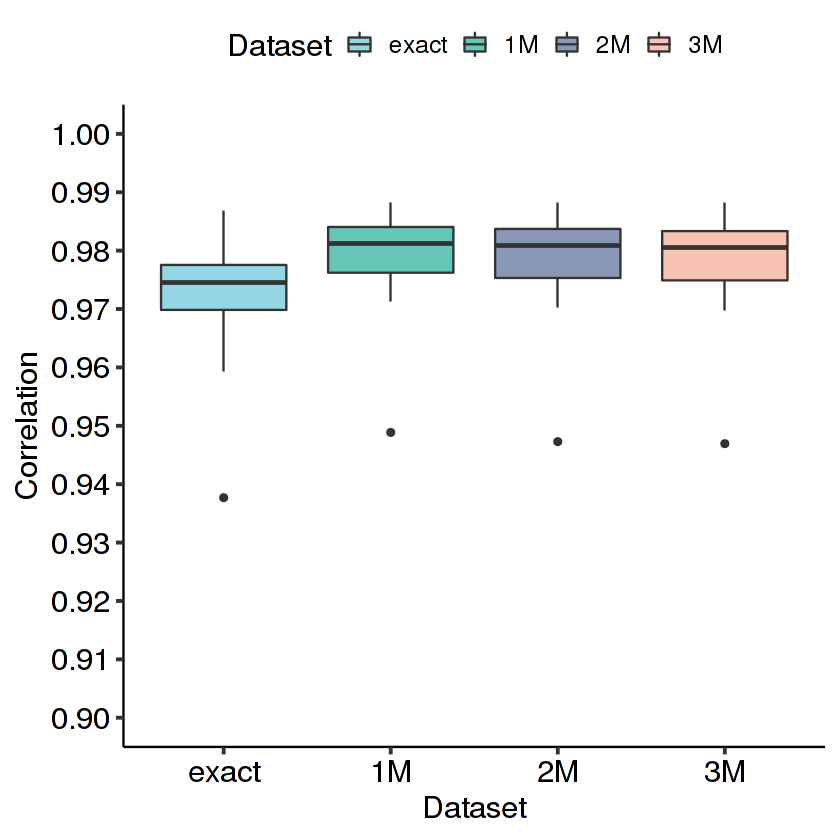

In [16]:
# Build correlation boxplot
dataset_correlation_boxplot <-
    ggplot(correlation_to_expected, aes(x = Dataset, y = Correlation, fill = Dataset)) +
        geom_boxplot() +
        scale_fill_manual(values = dataset_palette[2:5]) +
        scale_y_continuous(breaks = pretty_breaks(10), limits = c(0.9, 1)) +
        theme_pubr(base_size = 18)
# Save correlation boxplot
ggsave(file.path('post-analysis', 'dataset_correlation_boxplot.png'), 
       dataset_correlation_boxplot,
       device = 'png', dpi = 200,
       width = 10, height = 10)
# Show correlation boxplot
dataset_correlation_boxplot

We can look at some summary statistics (range, mean, median) of the correlation values in each dataset.

In [17]:
tapply(correlation_to_expected$Correlation, correlation_to_expected$Dataset, summary)

$exact
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9377  0.9698  0.9746  0.9724  0.9775  0.9869 

$`1M`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9489  0.9762  0.9812  0.9791  0.9840  0.9883 

$`2M`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9473  0.9753  0.9808  0.9786  0.9837  0.9883 

$`3M`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9469  0.9749  0.9805  0.9782  0.9833  0.9882 


*** 

## Comparing count data

Next, we can take the T0 samples which are the most likely to be similar, being from an early timepoint, and generate a scatter plot of observed vs expected counts. In red, we highlight those counts which have an absolute (negative or positive) difference of more than 100 reads.

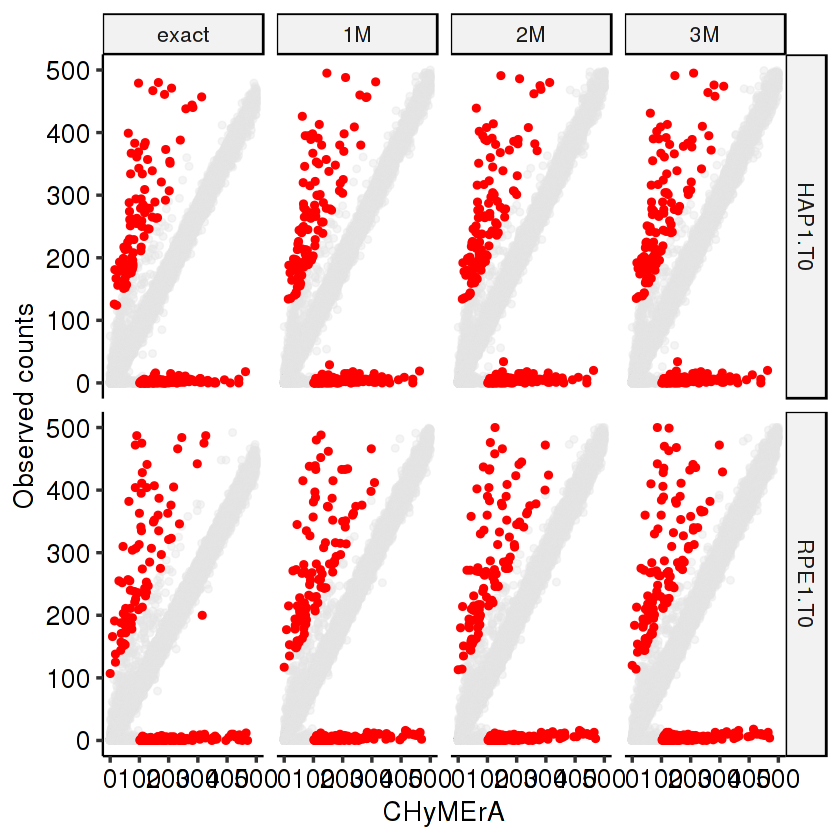

In [18]:
# Get subset of count data at T0
T0_subset <- gathered_counts_with_expected %>% filter(grepl('T0', Sample.Label))

# Scatter plot of observed vs expected counts
# Highlight those which have an absolute difference of > 100 reads
T0_count_scatter <-
ggplot(T0_subset %>% filter(CHyMErA <= max_counts_to_plot & Counts <= max_counts_to_plot), aes(x = CHyMErA, y = Counts)) +
        geom_point(alpha = 0.4, color = 'gray90') +
        geom_point(data = subset(T0_subset, CHyMErA <= max_counts_to_plot & Counts <= max_counts_to_plot & abs(CHyMErA - Counts) > 100), color = 'red') +
        facet_grid(Sample.Label ~ Dataset) +
        ylab('Observed counts') +
        theme_pubr(base_size = 16) 


# Save correlation boxplot
ggsave(file.path('post-analysis', 'T0_count_scatter.png'), 
       T0_count_scatter,
       device = 'png', dpi = 200,
       width = 20, height = 20)

# Show scatter plot
T0_count_scatter

We can see that there are a subset of guides which differ such that the observed counts are very low while the expected counts are very high and visa versa. To explore this, we take the guide pair which has less than 20 observed reads but the greatest expected counts. 

In [19]:
# Explore low observed counts that have high expected counts
# Find guide with the highest expected count
T0_subset %>% filter(Counts < 20 & CHyMErA > 500) %>% arrange(-CHyMErA) %>% head()

,id,Sample.Label,CHyMErA,Dataset,Counts
,<chr>,<chr>,<int>,<fct>,<int>
1,ParalogV3_070327,HAP1.T0,890,exact,14
2,ParalogV3_061214,RPE1.T0,663,exact,12
3,ParalogV3_061214,RPE1.T0,663,1M,12
4,ParalogV3_061214,RPE1.T0,663,2M,12
5,ParalogV3_061214,RPE1.T0,663,3M,12
6,ParalogV3_070327,RPE1.T0,620,exact,13


We can then get the annotations for this guide pair (ParalogV3_070327).

In [20]:
# Get library information for guide with the highest expected counts which has low observed counts
all_counts %>% filter(id == 'ParalogV3_070327') %>% select(id, sgrna_ids, sgrna_seqs, gene_pair_id) %>% unique()

,id,sgrna_ids,sgrna_seqs,gene_pair_id
,<chr>,<chr>,<chr>,<chr>
1,ParalogV3_070327,chr1:217431258-217431278_-|chr14:76173544-76173567_+,GCCTTGGACGAGATGGCAAG|GGGTACCATACTCGCTTGAATCG,GPATCH2|GPATCH2L


Next, we take the first guide sequence from the pair, remove the first and last bases and search for similar sequences.

In [21]:
# Search for similar sequences by removing first and last base from guide sequence
all_counts %>% select(id, sgrna_ids, sgrna_seqs, gene_pair_id) %>% unique() %>% filter(grepl("CCTTGGACGAGATGGCAA", sgrna_seqs))

id,sgrna_ids,sgrna_seqs,gene_pair_id
<chr>,<chr>,<chr>,<chr>
ParalogV3_070325,chr1:217431258-217431278_-|chr14:76166659-76166682_+,GCCTTGGACGAGATGGCAAG|CAGTGAAACCAGCAGTGTGTGTA,GPATCH2|GPATCH2L
ParalogV3_070326,chr1:217431258-217431278_-|chr14:76154619-76154642_+,GCCTTGGACGAGATGGCAAG|GTGACTCTGATGACACAATGGTA,GPATCH2|GPATCH2L
ParalogV3_070327,chr1:217431258-217431278_-|chr14:76173544-76173567_+,GCCTTGGACGAGATGGCAAG|GGGTACCATACTCGCTTGAATCG,GPATCH2|GPATCH2L
ParalogV3_070328,chr1:217431258-217431278_-|chr14:76171841-76171864_+,GCCTTGGACGAGATGGCAAG|GGTGATGACGAACAGAGTGATTG,GPATCH2|GPATCH2L
ParalogV3_070329,chr1:217431258-217431278_-|chr14:76176643-76176666_+,GCCTTGGACGAGATGGCAAG|GGGACTGAGAGGATAAGCCATAT,GPATCH2|GPATCH2L
ParalogV3_070330,chr1:217431258-217431278_-|chr13:62120704-62120727_+,GCCTTGGACGAGATGGCAAG|GGAGTTCCCCGGAAAAATCAGAA,GPATCH2|---
ParalogV3_070331,chr1:217431259-217431279_-|chr14:76166659-76166682_+,GGCCTTGGACGAGATGGCAA|CAGTGAAACCAGCAGTGTGTGTA,GPATCH2|GPATCH2L
ParalogV3_070332,chr1:217431259-217431279_-|chr14:76154619-76154642_+,GGCCTTGGACGAGATGGCAA|GTGACTCTGATGACACAATGGTA,GPATCH2|GPATCH2L
ParalogV3_070333,chr1:217431259-217431279_-|chr14:76173544-76173567_+,GGCCTTGGACGAGATGGCAA|GGGTACCATACTCGCTTGAATCG,GPATCH2|GPATCH2L


Here, we notice that there are two guides targeting the same gene (GPATCH2) which are shifted by 1bp with respect to the reference sequence:

```
chr1:217431258-217431278_-    -GCCTTGGACGAGATGGCAAG
chr1:217431259-217431279_-    GGCCTTGGACGAGATGGCAA-

```

In `metadata` is a list of [ambiguous guides](metadata/ambiguous_guides.tsv) which have 1 bp differences. We can then highlight these 'ambiguous' guides on the scatter plot.

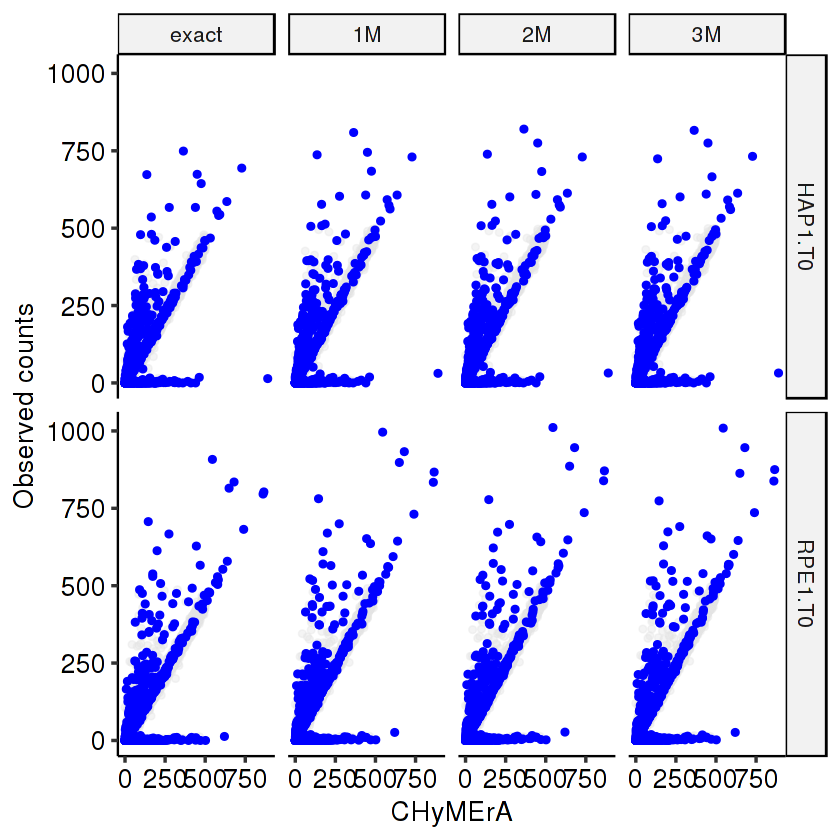

In [22]:
# Read annotations for guides which are shifted by 1bp at the ends with respect to another guide in the library (potentially ambiguous guides)
ambiguous_guides <- read.delim(file.path('metadata', 'ambiguous_guides.tsv'), header = F, sep = "\t") %>% pull(V2)

# Scatter plot of observed vs expected counts
# Highlight those which are in ambiguous_guides.tsv
T0_count_scatter_ambiguous <-
ggplot(T0_subset %>% filter(CHyMErA <= max_counts_to_plot & Counts <= max_counts_to_plot), aes(x = CHyMErA, y = Counts)) +
        geom_point(alpha = 0.4, color = 'gray90') +
        geom_point(data = subset(T0_subset, id %in% ambiguous_guides), color = 'blue') +
        facet_grid(Sample.Label ~ Dataset) +
        ylab('Observed counts') +
        theme_pubr(base_size = 16) 

# Save correlation boxplot
ggsave(file.path('post-analysis', 'T0_count_scatter_highlight_ambiguous.png'), 
       T0_count_scatter_ambiguous,
       device = 'png', dpi = 200,
       width = 20, height = 20)

# Show scatter plot
T0_count_scatter_ambiguous

A large proportion of guides which have the highest absolute differences fall into our ambiguous guides. It is likely that most alignment-based approachs will vary in their quantification of such guides. 